# Невронни мрежи:

* Невронни мрежи и техните свойства
* Активационни функции
* Backpropagation
* Update rules
* Ще построим граф за автоматично смятане на градиентите

In [1]:
import math

import numpy as np
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import display

%matplotlib inline
sns.set()

In [2]:
def plot_boundary(clf, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    f, ax = plt.subplots(figsize=(10, 8))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k')
    
    plt.show()

# Защо ни трябват невронни мрежи?

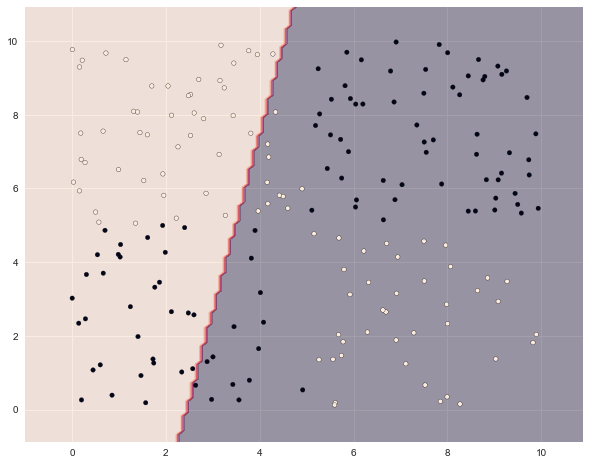

In [3]:
np.random.seed(1)
X = np.random.rand(200, 2) * 10
y = np.logical_xor(X[:, 0] > 5, X[:, 1] > 5)

lr = LogisticRegression().fit(X, y)
plot_boundary(lr, X, y)

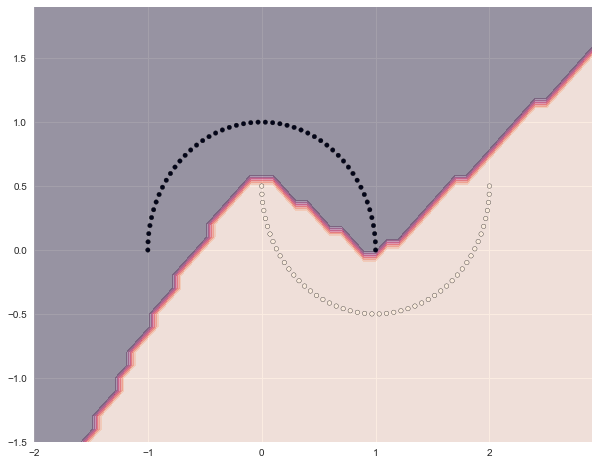

In [5]:
X, y = make_moons()
plot_boundary(mlp.fit(X, y), X, y)

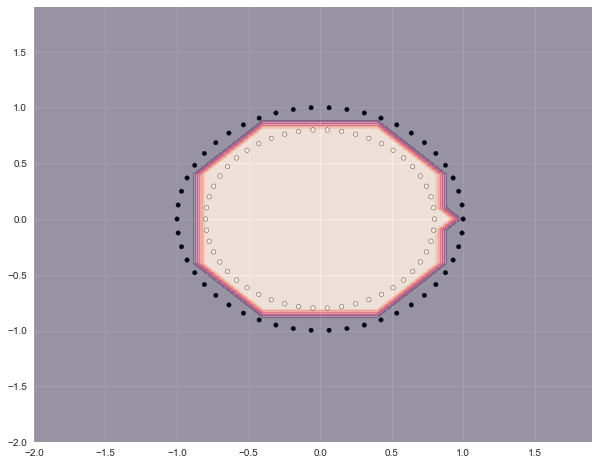

In [6]:
X, y = make_circles()
plot_boundary(mlp.fit(X, y), X, y)

In [7]:
mlp

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=100, learning_rate='constant',
       learning_rate_init=0.001, max_iter=2000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

# Параметри на мрежите:

* Архитектура
* Брой слоеве
* Брой неврони във всеки слой
* Активации
* Правило за обновяване на теглата + learning rate
* Размер на "партидата"
* Регуларизации

# Активации

Ще разгледаме някои от основните активации:
* sigmoid
* relu
* tanh
* leaky_relu
* softmax
* и др.


In [16]:
def plot_activations():
    x = np.linspace(-5, 5)
    plt.figure(figsize=(12,8))
    plt.plot(x, sigmoid(x));
    plt.plot(x, list(map(np.math.tanh, x)));
    plt.plot(x, relu(x));
    plt.plot(x, leaky_rely(x));    
    plt.plot(x, softplus_function(x));        
    plt.plot(x, softsign_function(x));        
    plt.plot(x, elu(x));
    plt.legend([
        "sigmoid",
        "tanh",
        "relu",
        "leaky_rely",
        "softplus_function",
        "softsign_function",
        "elu",
    ])

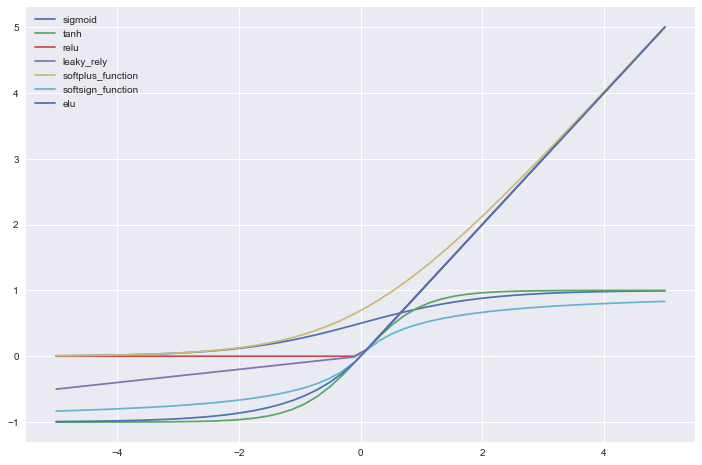

In [17]:
plot_activations()

# Невронните мрежи работят в два режима:

## За предсказване позлва "forward pass"

* Пресмятат се всички изчисления в графа за подадените X, W, b и активации.

## За да оптимизира теглата W и b се ползва "back propagation"

* Пресмята градиентите, чрез частните производни на изхода спрямо входа.
* Използва градиентите за да обнови теглата чрез `"the update rule"`.

# Forward pass

# При логистична регресия:

$$ \hat{y} = \sigma(w^Tx+b) = \sigma(b + w_1 x_1 + w_2 x_2 + \ldots + w_n x_n) $$

Където:

$$ \sigma(z) = \frac{1}{1 + e^{-z}} $$

$w$ e вектор.

$b$ е скалар.

$x$ е вектор със стойности, но операциите могат да бъдат "векторизарани" и $X$ да е матрица, съдържаща стойностите за всички семпли от данните.


Броя на параметрите ($W$ и $b$) е: $n + 1$, където е $n$ е броя фичъри.

Примерно, ако имаме 1000 фичъра ще имаме 1001 параметри (тегла) на логистичната регресия.

В случая на NN това е само един от невроните в някой от слоевете.

# При 2-слойна NN:

$$ h_1 = g(W_1^Tx+b_1) $$
$$ \hat{y} = \sigma(W_2^T h_1 + b_2 )$$

Където:

$$ \sigma(z) \text{ - логистична функция (сигмоид)}$$ 
$$ g(z) \text{ - някоя активация}$$ 


за всеки неврон в $h_1$, имаме:
$$ h_{1(i)} = g(W_{1(i)}^T x+b_i) $$

Във втория слой има само 1 неврон. Ако приемем, че резултатите след активацията в $h_1$ са нови фичъри - $x_2$, то:
$$ \hat{y} = \sigma(w_2^T x_2 + b_2 ) \text{ - е логистична регресия, която работи с новите фичъри $x_2$.} $$

$W_1$ - е матрица, съдържаща теглата за всяко $x$ за всеки от невроните в слой 1.

$b_1$ - вектор съдържащ "the intercept" за всеки от невроните в слой 1.

Аналогично за слой 2.

# Брой тегла в `MLP`, който ползвахме в началото.

* `W1` - (2, 100) 
* `W2` - (100, 1)


* `x` съдържа 2 фичъра
* `W1` - 2 реда, 100 колони - Има 100 неврона във слой 1. Всеки от тези 100 неврона ще има по 2 тегла за 2та фичъра.
* `W2` - 100 реда, 1 колона - Има само 1 изходен неврон (класификация или регрисия). Този неврон има 100 тегла, за 100те неврона от предходния слой.

Аналогично за `intercept`. Всеки неврон се нуждае от собствен `intercept`.

In [21]:
b1, b2 = mlp.intercepts_
print(b1.shape, b2.shape)

# b1 - 100 intercepts - one for each of the neurons in h1
# b2 - a intercetp for the final classification neuron (logistic regression)

(100,) (1,)


# Брой на теглата в скрития слой:

$W_1$ – бр. на фичърите * бр. на скритите неврони 
<br/>$b_1$ – бр. на скритите неврони
<br/>$h_1$ – общо $W_1$ + $b_1$ 

За слой 1:

* Вход: 2 фичъра
* Скрит слой 1: 100 неврона
* Изход: 1 неврон

бр. теглата $= 2 * 100 + 100 = 300 $


### Колко е броя на параметрите за слой 2?

# Демо

http://playground.tensorflow.org/

# Back propagation

Backpropagation е алгоритъма, който изплозваме за да намерим подходящи тегла за модела.

# Става лесно, посредством "update rule":

$$W_{current} = W_{current} - \alpha \nabla J(W_{current}) $$

# Градиента се смята по-сложно отколкото при логистичната регресия.

Заради това ще добавим още две техники:
* Computational Graph
* Chain Rule

# Случайно инициализиране на $W$

* Какво ще се случи ако всички тегла са 0 или 1?

# Кой алгоритъм за обновяване на теглата да ползваме?

* Ако искате най-добрите резултати, ще трябва да правите грид сърч с параметрите на всички.
* Adam дава много добри резултати в повечето случаи със стойностите по подразбиране.

[Хубав туториал за оптимизационните алгоритми](http://ruder.io/optimizing-gradient-descent/index.html)

# Graph

Целта на графа е да вкараме всички операции от примера и да имаме автоматично диференциране и ъпдейтване на теглата.

## Елементите на графа трябва да имат следните функционалности:
* `forward` - пресямата операцията.
* `backward` - пресмята и запомня градиентите за текущата операция.
* `update weights` - обновява теглата с помощтта на "the update rule".

## Изпълниние на графа:
* Когато се изпълнява, графа първо ще извика `forward` за всеки от елементите и ще запази стойностотите им.
* След което преизползваме стойностите в `backward pass`, изпълнявайки го върху елементите в обратен ред.
* Накрая чрез  `update_wights` ще извадим пресметнатите градиенти от съответните им тегла.

# Ще направим граф за многослойна NN за регресия.

## За улеснение няма да е точно граф - по-точно няма да има разклонения.
Ще започнем отзад напред и първо ще дефинираме `MSE` - `op4` от примера. 
* Последната операция (cost) - няма да имплементира `update_weights` по очевидни причини. 

In [23]:
class Linear:
    def __init__(self, x_dim, h_dim, name=None):
        self.W = np.random.randn(x_dim, h_dim)
        self.b = np.random.randn(h_dim)
        self.name = name
        
    def forward(self, X):
        self.X = X
        self.values = np.dot(X, self.W) + self.b
        return self.values

    def backward(self, dZ):
        self.db = np.dot(np.ones((1, dZ.shape[0]), dtype=np.float64), dZ)
        self.dW = np.dot(np.transpose(self.X), dZ)

        if dZ.ndim == 1:
            dZ = np.expand_dims(dZ, axis=1)

        self.dX =  dZ @ np.transpose(self.W)
        return self.dX

    def update(self, alpha):
        self.W += - alpha * self.dW.reshape(self.W.shape)
        self.b += - alpha * self.db.ravel()

# В `__init__` подаваме `x_dim` и `h_dim`.


* `x_dim` - колко фичъра има в `x`.
* `h_dim` - колко скрити неврона искаме да има в новия слой.

`h_dim` може да бъде `1` за последния слой.

* Когато умножим `X` по `W` ще получим нова матрица. 
* Броя на редовете ще си остане същия (семплите), броя на колоните ще са новите неврони (фичъри) в скрития слой.

Ред по колона :D

![](imgs/matrix-multiply-a.svg)

# Следва кода за `Sigmoid`


In [24]:
class Sigmoid:
    def forward(self, X):
        self.values = 1.0 / (1.0 + np.exp(-X))
        return self.values

    def backward(self, dZ):
        return (1.0 - self.values) * self.values * dZ

In [26]:
from sklearn.base import BaseEstimator

class NeuralNetwork(BaseEstimator):
    def __init__(self, model, alpha=0.01, iterations=100):
        self.alpha = alpha
        self.iterations = iterations
        self.model = model
    
    def fit(self, X, y=None):
        model = self.model
        self.errors = []
        
        for i in range(self.iterations):
            z = X
            for e in self.model:
                z = e.forward(z)
                if isinstance(e, MSE):
                    self.errors.append(e.value)

            dZ = None
            for e in self.model[::-1]:
                dZ = e.backward(dZ)

            for e in self.model:
                if hasattr(e, 'update'):
                    e.update(self.alpha)
                    
        return self
        
    def predict(self, X):
        z = X
        for e in model[:-1]:
            z = e.forward(z)
        return z


# Готово. Да пробваме графа!

In [27]:
X = np.array([
    [1, 2, 3],
    [-1, -2, -3]
])

y = np.array([0, 1])

In [28]:
np.random.seed(1)

model = [
    Linear(3, 5, "Linear 1"),
    Sigmoid(),

    # Linear(5, 4, "Linear 2"),
    # Sigmoid(),
    
    Linear(5, 1, "Linear 3"),
    MSE(y)
]

nn = NeuralNetwork(model)
nn.fit(X)
nn.predict(X)

array([[-0.02867645],
       [ 1.02624718]])

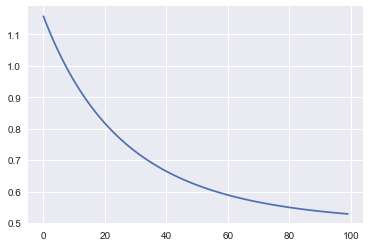

In [29]:
plt.plot(nn.errors);

In [30]:
def plot_different_lr():
    plt.figure(figsize=(12,12))
    for i, lr in enumerate([0.001, 0.01, 0.1, 0.4, 0.5, 0.6]):
        np.random.seed(1)
        model = [Linear(3, 5, "Linear 1"), Sigmoid(), Linear(5, 1, "Linear 3"), MSE(y)]
        nn = NeuralNetwork(model, alpha=lr)
        nn.fit(X)
        plt.subplot(2,3, i+1)
        plt.title(lr)
        plt.plot(nn.errors);

/Users/lachezar/.pyenv/versions/3.6.2/envs/fmi-explore/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


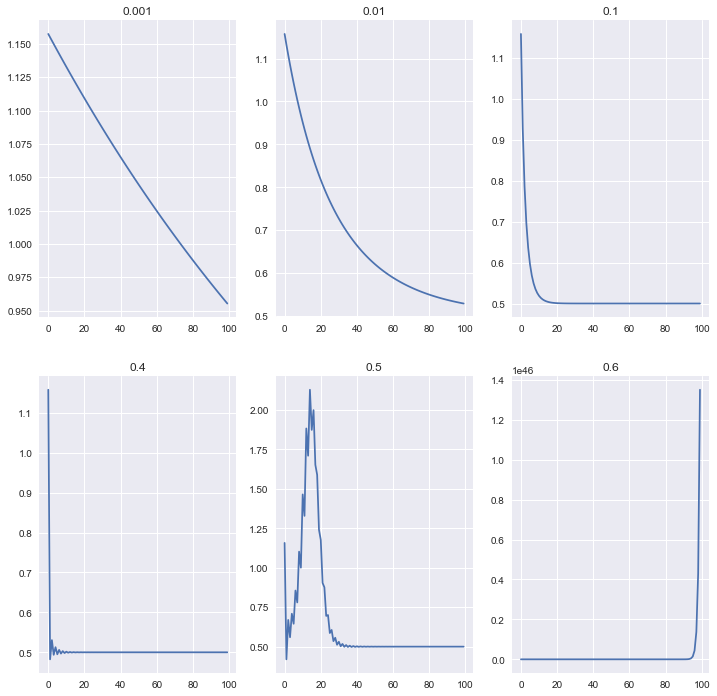

In [31]:
plot_different_lr()

# Да го сравним с `LinearRegression`

In [32]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [33]:
boston = load_boston()
X = boston.data
X = StandardScaler().fit(X).transform(X)
y = boston.target

x_train, x_test, y_train, y_test = train_test_split(X, y)

regressor = LinearRegression().fit(x_train, y_train)
print("train score:", regressor.score(x_train, y_train))
print("test score:", regressor.score(x_test, y_test))


train score: 0.736897285102
test score: 0.742545680576


/Users/lachezar/.pyenv/versions/3.6.2/envs/fmi-explore/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [34]:
x_train.shape

(379, 13)

In [35]:
np.random.seed(1)
model = [
    Linear(13, 100, "Linear 1"),
    Sigmoid(),

    Linear(100, 50, "Linear 2"),
    Sigmoid(),
    
    Linear(50, 1, "Linear 3"),
    MSE(y_train)
]

nn = NeuralNetwork(model, alpha=0.0001, iterations=1000)
nn.fit(x_train);

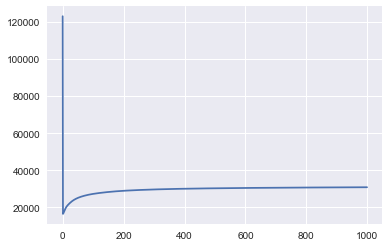

In [36]:
plt.plot(nn.errors);

In [37]:
print(r2_score(y_train, nn.predict(x_train)))


0.976173280251
0.832469042921


In [ ]:
Както видяхме нашата невронна мрежа получи по-добри резултати от линейната регресия.